# Fitting a Line Using MCMC
By Griffin Hosseinzadeh (2019 April 17)  
Updated by Charlotte Mason (2020 August 28)  
Updated by Griffin Hosseinzadeh (2025 April 30)

In [23]:
import numpy as np
import matplotlib.pyplot as plt

import emcee
import corner

## Generate Some Fake Data
Choose a slope $m$, intercept $b$, and scatter $\sigma$, and generate $N$ random points using the `np.random` module. Plot the results to see what your data look like. Our goal is to recover the parameters defined here. (Hint: this section is identical to the previous notebook.)

<ErrorbarContainer object of 3 artists>

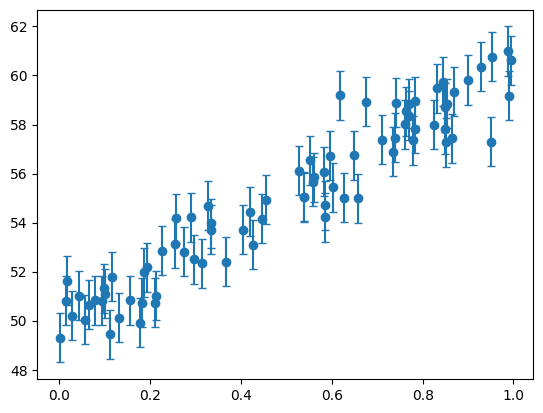

In [24]:
N = 80  # number of points
m = 10.  # slope
b = 50.  # intercept
sigma = 1.  # scatter

rng = np.random.default_rng()
x =  np.random.uniform(0,1,N)
y = m*x+b+np.random.normal(0,sigma,N) # equation for a line PLUS random values from a Gaussian centered at 0 with standard deviation `sigma`
dy =  sigma# array of error bars for all the data (all `sigma`)

plt.errorbar(x, y, yerr=sigma, fmt="o", capsize=3)

## Write Down the Posterior
Define functions that return the prior, the likelihood, and the posterior given a parameter vector `theta = [m, b]`. For computational accuracy (and convenience), we actually want to do this in log space. You can either use `np.log` (natural log) or `np.log10` (base-10 log). Regardless of the shape of your prior, it's good practice to limit the values of $m$ and $b$ to some reasonable range. (Hint: this section is identical to the previous notebook.)

In [25]:
m_min = 0.
m_max = 100.
b_min = 0.
b_max = 100.

def log_prior(theta):
    """
    Returns log(prior) for a given parameter vector
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
    
    Returns
    -------
    ln_prior: float
        Natural log of the prior probability function
    """
    if m_min<theta[0]<m_max:
        m_prior=1
    else:
        m_prior=0

    if b_min<theta[1]<b_max:
        b_prior=1
    else:
        b_prior=0

    ln_prior=np.log(b_prior*m_prior)
    
    return ln_prior


def log_likelihood(theta, x, y, dy):
    modelval = theta[0] * x + theta[1]
    val = ( -0.5 ) * ( np.log ( 2 * np.pi * sigma ** 2 ) + ( ( y - modelval )/ sigma ) ** 2 )
    log_lik = np.sum(val)
    return log_lik
    
def log_posterior(theta, x, y, dy):
    return log_likelihood(theta,x,y,dy) + log_prior(theta)

## Set Up the Ensemble Sampler
This time we will use the `emcee` package that you imported above to sample the posterior probability distribution. Everything you need is contained within the `emcee.EnsembleSampler` class. Initialize this with 100 walkers and the `log_posterior` function you defined above. Don't forget that `log_posterior` takes additional arguments `x`, `y`, and `dy`. (Hint: check the documentation for `EnsembleSampler` for how to deal with this.)

Note, we will initialise the sampler in #1.5

In [26]:
n_walkers = 100
n_params =  2
args =  [x,y,dy]

## Setup random initial guesses for the starting positions

You'll need to give initial guesses for each walker, which you can draw randomly from the prior. 

In [27]:
m_random =  np.random.normal(9,5, n_walkers)
b_random =  np.random.normal(45,10, n_walkers)


initial_guesses = np.array([[m_random[i], b_random[i]] for i in range(n_walkers)])

print(initial_guesses)

[[ 4.28637855 50.42021897]
 [10.11011872 34.34274709]
 [ 6.37111004 48.3695398 ]
 [15.32526218 39.05773203]
 [12.97143506 53.46468422]
 [14.32882052 46.92016702]
 [ 8.46332215 54.71300333]
 [10.83482432 43.21032581]
 [ 2.47507097 38.91032852]
 [13.0480306  38.10498164]
 [ 7.81804579 41.65009377]
 [ 5.0274555  49.54828916]
 [10.56489623 26.62360147]
 [ 2.91283323 46.34991246]
 [11.80315194 42.60166565]
 [ 8.51765368 31.5068796 ]
 [ 6.64630032 50.35702163]
 [17.71142411 47.55241413]
 [14.85944463 57.88214423]
 [ 1.41994697 51.31331767]
 [ 9.29407202 59.33956321]
 [ 9.10213478 37.22390419]
 [ 6.34159724 52.4614659 ]
 [ 3.14477119 44.33522409]
 [ 3.2723372  46.32076391]
 [12.00679354 27.46500358]
 [12.21421746 37.18282881]
 [ 7.19516393 45.24992047]
 [10.99287349 37.39456022]
 [17.00343432 59.06091565]
 [ 5.78846639 53.91456399]
 [ 6.82778738 50.67958497]
 [ 6.08457325 53.55164314]
 [ 7.09416022 22.54641905]
 [ 7.47177205 57.67986368]
 [ 9.82907928 24.30142207]
 [ 5.20754757 48.3139921 ]
 

## Initialize and run!

Initialize the `EnsembleSampler` object and then run it with the `run_mcmc` method. For now, 10000 steps is more than enough, and should run in less than a minute on your laptop. If this command takes too long, ask for help.

In [28]:
n_steps = 1000
n_walkers = 100

sampler = emcee.EnsembleSampler(n_walkers, n_params,  log_posterior, args=args)

sampler.run_mcmc(initial_guesses, n_steps , progress = True)

C:\Users\lythe\AppData\Local\Temp\ipykernel_61776\2901790544.py:30: RuntimeWarning: divide by zero encountered in log
  ln_prior=np.log(b_prior*m_prior)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 192.71it/s]


State([[10.39878581 50.00135562]
 [10.40123664 49.78263669]
 [10.55607196 49.74273033]
 [10.4800797  49.86049775]
 [11.09610258 49.51671826]
 [10.40721914 49.85780853]
 [10.57097528 49.7501961 ]
 [10.97891404 49.27890722]
 [ 9.92268246 50.1766618 ]
 [10.43485977 49.86486607]
 [10.91780216 49.54117917]
 [10.45195916 49.80128155]
 [10.9946361  49.51828602]
 [10.26235867 50.08019061]
 [10.42255608 49.85191808]
 [10.1594853  49.90871256]
 [10.44982336 49.84929233]
 [10.17183883 50.01566235]
 [10.82670709 49.73256471]
 [ 9.9271429  50.12014484]
 [10.6623559  49.76479734]
 [10.15308677 49.98409841]
 [11.21196078 49.47028285]
 [10.39787532 49.81644395]
 [10.42197982 49.82197796]
 [10.09608109 49.98832766]
 [10.70663453 49.69011289]
 [10.08285671 49.95969477]
 [10.25913752 49.77232179]
 [10.590897   49.72068601]
 [10.47103716 50.0809422 ]
 [11.37189318 49.35562314]
 [10.41378091 49.86788161]
 [10.70917143 49.68050865]
 [10.38608366 49.7849924 ]
 [10.08197144 49.98400126]
 [10.61711688 49.77818

## Plot the Results
First make a plot of the walker positions (value of each parameter) at each step. Write a function to do this, since you'll be using it a lot.

(100, 1000, 2)


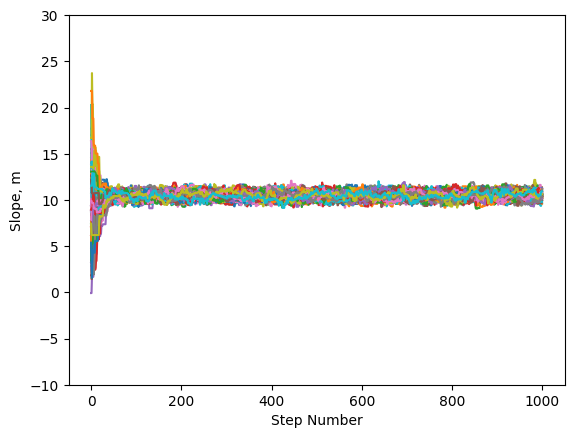

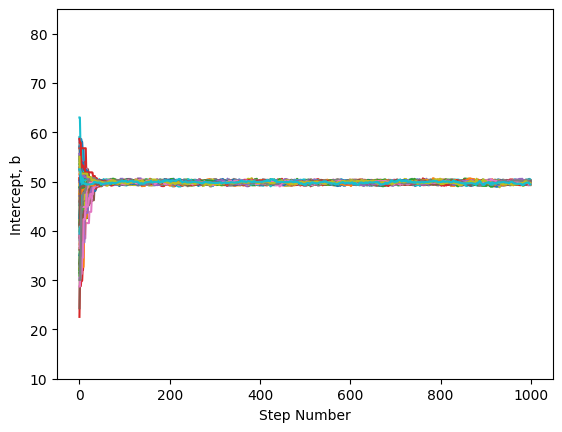

In [32]:
print(sampler.chain.shape)  # check that this has dimensions (n_walkers, n_steps, n_params)

def chain_plots(chain, **kwargs):
    """
    Plot the histories for each walker in sampler.chain
    
    Parameters
    ----------
    chain: ndarray
        3D array given by sampler.flatchain, with shape (n_walkers, n_steps, n_params)
    kwargs: `.Line2D` properties, optional
        All keyword arguments are passed to `pyplot.plot`
    """
    
    plt.figure()
    plt.plot(sampler.chain[:,:,0].T)  # complete
    #plt.xlim(500,0)
    plt.xlabel('Step Number')
    plt.ylim(-10, 30)
    #plt.yticks(np.arange(-20,51,5))
    plt.ylabel('Slope, m')

    plt.figure()
    plt.plot(sampler.chain[:,:,1].T)  # complete
    plt.xlabel('Step Number')
    plt.ylabel('Intercept, b')
    plt.ylim(10, 85)
    #plt.yticks(np.arang
    
chain_plots(sampler.chain)


Each one of those colored lines is a walker. They started out at your initial guesses. What do you immediately notice?

Try making more useful plots by zooming in on the relevant parts. Hint: you can adjust line opacity in matplotlib with the `alpha` parameter.

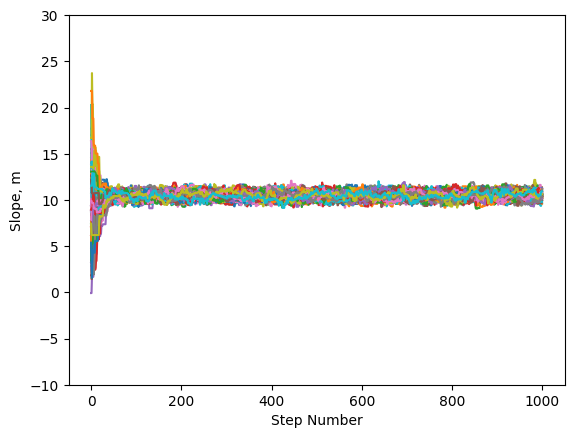

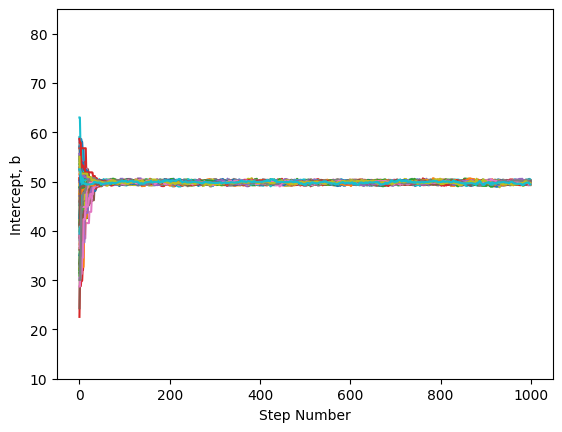

In [37]:
n_burn = 75
chain_plots( sampler.chain , start_idx= 75  , alpha = 0.5)

Are your chains converged? How many steps did it take for this to happen? This is called the "burn-in" period. **From now on, only use the steps after the burn-in period.**

Now make a scatter plot of the two parameters, one point for each walker-step. Hint: `sampler.flatchain`.

In [ ]:
# complete

How does this compare to the distribution you had in the previous notebook (assuming you used the same parameters)?

Now let's marginalize over each parameter. Given that we have walkers that are distributed according to the 2D posterior, think about how to calculate the marginalized posterior for each parameter.

In [ ]:
plt.figure()
# complete

plt.figure()
# complete

Calculate the medians and the 68% ($1\sigma$) confidence intervals for each parameter. Check your answers against the centers and widths of the distributions you just plotted above. Do they look about right?

In [ ]:
# complete
print(f'$m = {m_med:.2f}_{{{dm_lo:+.2f}}}^{{{dm_hi:+.2f}}}$')

# complete
print(f'$b = {b_med:.2f}_{{{db_lo:+.2f}}}^{{{db_hi:+.2f}}}$')

There's an easy way to generate all these plots and summary statistics: `corner.corner`! Produce a corner plot with the true parameters labeled and the best-fit values (with error bars) printed on the plot. How close did we get to the parameters we used to generate the data?

In [ ]:
corner.corner(  # complete

## Take-Away Message
MCMC is a much more efficient way to sample the probability distribution because the walkers mostly stay in the highest-probability region. Plus it essentially gives you the marginalized posteriors for free, because the density of walkers matches the probability density.

## Other Things to Try
- Add a parameter for the intrinsic scatter and redo the MCMC fit.
- Try implementing Metropolis-Hastings algorithm yourself and see if you can get the same results as `emcee`.